# Tensorflow Lite Model

In [1]:
!pip install opencv-python==4.1.2.30
!pip install ipywidgets==7.7.1
!pip install tensorflow==2.3.0
!pip install protobuf==3.20.3
!pip install matplotlib==3.3.4

In [2]:
import cv2
import ipywidgets.widgets as widgets
import random
import colorsys
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import time

In [41]:
def filter_boxes(box_xywh, scores, score_threshold, input_shape):
    scores_max = tf.math.reduce_max(scores, axis=-1)

    mask = scores_max >= score_threshold
    class_boxes = tf.boolean_mask(box_xywh, mask)
    pred_conf = tf.boolean_mask(scores, mask)
    class_boxes = tf.reshape(class_boxes, [tf.shape(scores)[0], -1, tf.shape(class_boxes)[-1]])
    pred_conf = tf.reshape(pred_conf, [tf.shape(scores)[0], -1, tf.shape(pred_conf)[-1]])

    box_xy, box_wh = tf.split(class_boxes, (2, 2), axis=-1)

    input_shape = tf.cast(input_shape, dtype=tf.float32)

    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]

    box_mins = (box_yx - (box_hw / 2.)) / input_shape
    box_maxes = (box_yx + (box_hw / 2.)) / input_shape
    boxes = tf.concat([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ], axis=-1)

    return (boxes, pred_conf)

def draw_bbox(image, bboxes, classes, colours, show_label=True):
    num_classes = len(classes)
    image_h, image_w, _ = image.shape

    out_boxes, out_scores, out_classes, num_boxes = bboxes
    for i in range(num_boxes[0]):
        class_ind = int(out_classes[0][i])
        if class_ind < 0 or class_ind >= num_classes: continue
        coor = out_boxes[0][i]
        coor[0] = int(coor[0] * image_h)
        coor[2] = int(coor[2] * image_h)
        coor[1] = int(coor[1] * image_w)
        coor[3] = int(coor[3] * image_w)

        fontScale = 0.5
        score = out_scores[0][i]
        
        bbox_color = colours[class_ind]
        c1, c2 = (int(coor[1]), int(coor[0])), (int(coor[3]), int(coor[2]))
        cv2.rectangle(image, c1, c2, bbox_color, 1)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            cv2.putText(image, bbox_mess, (c1[0], (c1[1] - 2)), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), 1, lineType=cv2.LINE_AA)

def setup_tflite(model_path, labels):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    class_names = {}
    with open(labels, 'r') as data:
        for ID, name in enumerate(data):
            class_names[ID] = name.strip('\n')

    hsv_tuples = [(1.0 * x / len(class_names), 1., 1.) for x in range(len(class_names))]
    colours = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    label_colours = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colours))

    random.seed(0)
    random.shuffle(label_colours)
    random.seed(None)

    return interpreter, input_details, output_details, class_names, label_colours

def detect_tflite(interpreter, input_details, output_details, img, class_names, label_colours, int8=False, score_thresh = 0.5, iou_thresh = 0.4, input_size=416):
    original_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_data = cv2.resize(original_image, (input_size, input_size))
    image_data = image_data / 255.

    images_data = []
    for i in range(1):
        images_data.append(image_data)
    images_data = np.asarray(images_data).astype(np.float32)
    interpreter.set_tensor(input_details[0]['index'], images_data)
    interpreter.invoke()
    pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

    if (int8 == True):
        NUM_CLASSES = len(class_names)
        STRIDES = np.array([16, 32])
        ANCHORS = (np.array([10,14, 23,27, 37,58, 81,82, 135,169, 344,319])).reshape(2, 3, 2)
        XYSCALE = [1.05, 1.05]
        bbox_tensors = []
        prob_tensors = []
        for i, fm in enumerate(pred):
            if i == 0:
                output_tensors = decode_tflite(pred[1], input_size // 16, NUM_CLASSES, STRIDES, ANCHORS, i, XYSCALE)
            else:
                output_tensors = decode_tflite(pred[0], input_size // 32, NUM_CLASSES, STRIDES, ANCHORS, i, XYSCALE)
            bbox_tensors.append(output_tensors[0])
            prob_tensors.append(output_tensors[1])

        pred_bbox = tf.concat(bbox_tensors, axis=1)
        pred_prob = tf.concat(prob_tensors, axis=1)
        pred = (pred_bbox, pred_prob)

    boxes, pred_conf = filter_boxes(pred[0], pred[1], score_thresh, input_shape=tf.constant([input_size, input_size]))
    
    boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
        boxes=tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
        scores=tf.reshape(
            pred_conf, (tf.shape(pred_conf)[0], -1, tf.shape(pred_conf)[-1])),
        max_output_size_per_class=50,
        max_total_size=50,
        iou_threshold=iou_thresh,
        score_threshold=score_thresh
    )

    pred_bbox = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]
    draw_bbox(original_image, pred_bbox, class_names, label_colours)
    return original_image

def decode_tflite(conv_output, output_size, NUM_CLASS, STRIDES, ANCHORS, i=0, XYSCALE=[1,1,1]):
    conv_raw_dxdy_0, conv_raw_dwdh_0, conv_raw_score_0,\
    conv_raw_dxdy_1, conv_raw_dwdh_1, conv_raw_score_1,\
    conv_raw_dxdy_2, conv_raw_dwdh_2, conv_raw_score_2 = tf.split(conv_output, (2, 2, 1+NUM_CLASS, 2, 2, 1+NUM_CLASS,
                                                                                2, 2, 1+NUM_CLASS), axis=-1)

    conv_raw_score = [conv_raw_score_0, conv_raw_score_1, conv_raw_score_2]
    for idx, score in enumerate(conv_raw_score):
        score = tf.sigmoid(score)
        score = score[:, :, :, 0:1] * score[:, :, :, 1:]
        conv_raw_score[idx] = tf.reshape(score, (1, -1, NUM_CLASS))
    pred_prob = tf.concat(conv_raw_score, axis=1)

    conv_raw_dwdh = [conv_raw_dwdh_0, conv_raw_dwdh_1, conv_raw_dwdh_2]
    for idx, dwdh in enumerate(conv_raw_dwdh):
        dwdh = tf.exp(dwdh) * ANCHORS[i][idx]
        conv_raw_dwdh[idx] = tf.reshape(dwdh, (1, -1, 2))
    pred_wh = tf.concat(conv_raw_dwdh, axis=1)

    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = tf.stack(xy_grid, axis=-1)  # [gx, gy, 2]
    xy_grid = tf.expand_dims(xy_grid, axis=0)
    xy_grid = tf.cast(xy_grid, tf.float32)

    conv_raw_dxdy = [conv_raw_dxdy_0, conv_raw_dxdy_1, conv_raw_dxdy_2]
    for idx, dxdy in enumerate(conv_raw_dxdy):
        dxdy = ((tf.sigmoid(dxdy) * XYSCALE[i]) - 0.5 * (XYSCALE[i] - 1) + xy_grid) * \
              STRIDES[i]
        conv_raw_dxdy[idx] = tf.reshape(dxdy, (1, -1, 2))
    pred_xy = tf.concat(conv_raw_dxdy, axis=1)
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    t1=time.time()
    return pred_xywh, pred_prob

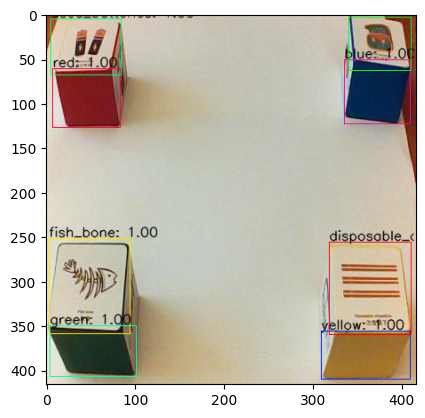

In [43]:
interpreter, input_details, output_details, class_names, label_colours = setup_tflite('yolov4-tiny-416.tflite', '../obj.names')

img = cv2.imread('../obj/nightstickers_2_jpg.rf.9830624cde375da317a81a406bd5120d.jpg')
img = detect_tflite(interpreter, input_details, output_details, img, class_names, label_colours)
plt.imshow(img)

In [44]:
with open('../train.txt', 'r') as f:
    dataset = [line.strip() for line in f.readlines()]
    
interpreter, input_details, output_details, class_names, label_colours = setup_tflite('yolov4-tiny-416.tflite', '../obj.names')

total_t = 0

for i in range(len(dataset)):
    t0 = time.time()
    img = cv2.imread(dataset[i])
    img = detect_tflite(interpreter, input_details, output_details, img, class_names, label_colours)
    t = time.time()
    diff = t-t0
    total_t += (diff)

print('average inference time =  {:.4f}'.format(total_t/len(dataset)))

average inference time =  0.0769


In [45]:
image_widget = widgets.Image(format='jpeg', width=680, height=460)
display(image_widget)

cap = cv2.VideoCapture('../IMG_4982.mov')

interpreter, input_details, output_details, class_names, label_colours = setup_tflite('yolov4-tiny-416.tflite', '../obj.names')

start_time = time.time()
fps_total = 0
frame_total = 0

while (cap.isOpened()):
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.resize(frame,(680, 460))
    frame = detect_tflite(interpreter, input_details, output_details, frame, class_names, label_colours)
    
    cur_time = time.time()
    elapsed_time = cur_time - start_time
    fps = 1/elapsed_time
    fps_total += fps
    frame_total +=1
    start_time = cur_time
    fps_txt = "FPS: {:.2f}".format(fps)
    cv2.putText(frame, fps_txt, (30,430), cv2.FONT_HERSHEY_COMPLEX_SMALL, 1, (0, 0, 255), 1)
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    image_widget.value = cv2.imencode('.jpg', frame)[1].tobytes()
    
cap.release()
avg = fps_total / frame_total

print("Avg fps: {:.2f}".format(avg))

Image(value=b'', format='jpeg', height='460', width='680')

Avg fps: 9.36
